In [1]:
import numpy as np
import pandas as pd
import re
import requests
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [2]:
data = pd.read_csv('/home/yinaihua/Desktop/时间序列/期末作业/chapter-07/USB.csv')

In [3]:
print(data.head())

    USB.Open   USB.High    USB.Low  USB.Close  USB.Volume  USB.Adjusted
0  35.610001  36.290001  35.610001  36.169998     7697500     25.120195
1  36.169998  36.250000  35.910000  36.200001     5409000     25.141035
2  36.189999  36.189999  35.700001  35.770000     5748100     24.842396
3  35.700001  36.189999  35.490002  35.650002     5752100     24.759054
4  35.730000  35.880001  35.360001  35.630001     6548400     24.745163


In [4]:
print(data.dtypes)

In [5]:
Open=data['USB.Open']
Close=data['USB.Close']
#print(Open[0])


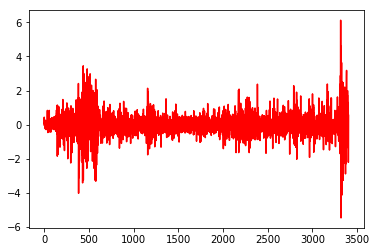

In [6]:
shoupanjia=Close[::-1]
rishouyi = shoupanjia.diff(1)
plt.plot(rishouyi,'r-')

In [7]:
Close_log = np.log(Close)
rishouyi_log = Close_log.diff(1)
rishouyi_log.dropna(inplace=True)

In [8]:
def SimAnlysis_ts(ts, w):
    roll_mean = ts.rolling(window = w).mean()#w个数据为一个窗口，取均值
    roll_std = ts.rolling(window = w).std()  #取方差
    pd_ewma = ts.ewm(span=w).mean()# # 指数平均线。ts：数据；span：时间间隔

    plt.clf()
    plt.figure()
    plt.grid()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.plot(pd_ewma, color='yellow', label = 'EWMA')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')##滑动平均值和标准偏差
    plt.show()
    #plt.savefig('./图片/'+title+'.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

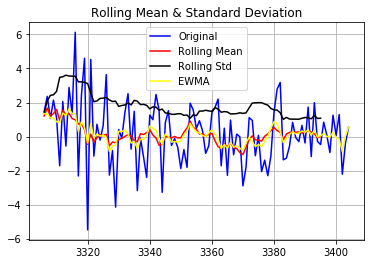

In [9]:
SimAnlysis_ts(rishouyi[1:100],10)

In [10]:
def adf_test(ts):
    from statsmodels.tsa.stattools import adfuller
    adftest = adfuller(ts)
    adf_res = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])

    for key, value in adftest[4].items():
        adf_res['Critical Value (%s)' % key] = value
    return adf_res

In [11]:
adf_test(rishouyi[1:100])
#第一个是adt检验的结果，也就是t统计量的值。
#第二个是t统计量的P值。小于p值拒绝原假设
#第三个是计算过程中用到的延迟阶数。
#第四个是用于ADF回归和计算的观测值的个数。
#第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。
##如果1%比5%小证明平稳，反正证明不平稳。根据结果看出来，你的数据不平稳。
#################所以，这个数据平稳

Test Statistic                 -2.652837
p-value                         0.082561
Lags Used                       6.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64

In [12]:
def draw_acf_pacf(ts, w):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    plot_acf(ts, ax = ax1, lags=w)
    ax2 = fig.add_subplot(212)
    plot_pacf(ts, ax=ax2, lags=w)

    plt.show()
    #plt.savefig('./PDF/test_acf_pacf.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

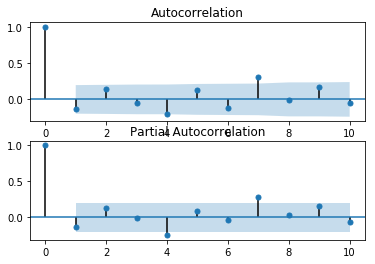

In [13]:
draw_acf_pacf(rishouyi[1:100],10)

In [14]:
rishouyi_lags=int(adf_test(rishouyi[1:100])['Lags Used'])
print(rishouyi_lags)

6


In [15]:
def draw_ar(ts, w):
    from statsmodels.tsa.arima_model import ARMA, ARIMA
    arma = ARMA(ts, order=(w,0)).fit(disp=-1)
    ts_predict = arma.predict(0,len(ts))
    print('置信水平为',arma.conf_int())

    plt.clf()
    plt.plot(ts_predict, label="Predict")
    plt.plot(ts, label = "Original")
    plt.legend(loc="best")
    plt.title("AR Test %s" % w)
    plt.show()
    #plt.savefig("./PDF/test_ar_"+ str(w) +".pdf", format='pdf')

/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

置信水平为                         0         1
const           -0.118558  0.477343
ar.L1.USB.Close -0.291868  0.101739
ar.L2.USB.Close -0.048802  0.347635
ar.L3.USB.Close -0.253624  0.137445
ar.L4.USB.Close -0.419369 -0.027556
ar.L5.USB.Close -0.120260  0.277673
ar.L6.USB.Close -0.237646  0.158665


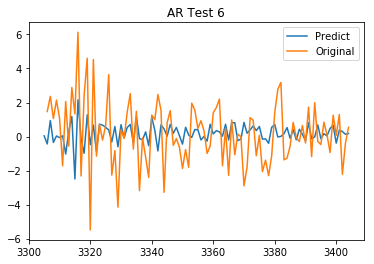

In [16]:
zhixinshuip=draw_ar(rishouyi[1:100],6)

In [17]:
##########滑动平均模型开始
def draw_ma(ts, w):
    from statsmodels.tsa.arima_model import ARMA, ARIMA
    ma = ARMA(ts, order=(0, w)).fit(disp = -1)
    ts_predict_ma = ma.predict(0,len(ts))
    print()
    
    ar = ARMA(ts, order=(w,0)).fit(disp=-1)
    ts_predict_ar = ar.predict(0,len(ts))    

    plt.clf()
    plt.plot(ts_predict_ar, label="AR")
    plt.plot(ts_predict_ma, label="MA")
    plt.plot(ts, label = "ORG")
    plt.legend(loc="best")
    plt.title("MA Test %s" % w)
    #plt.savefig("./PDF/test_ma_"+ str(w) +".pdf", format='pdf')
    plt.show()
    return ts_predict_ma

---------------------------MA TEST--------------
ADF test results (ema diff):
 Test Statistic                 -2.652837
p-value                         0.082561
Lags Used                       6.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64



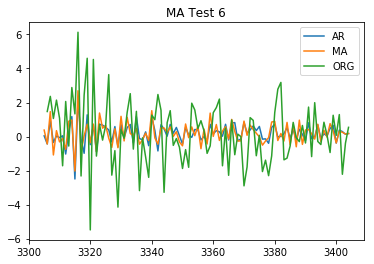

In [19]:
#######滑动平均模型
print('---------------------------MA TEST--------------')
adf_res = adf_test(rishouyi[1:100])
print ('ADF test results (ema diff):\n', adf_res)
ma_predict = draw_ma(rishouyi[1:100],6)
#rtn_test(ma_predict, "ma predict")

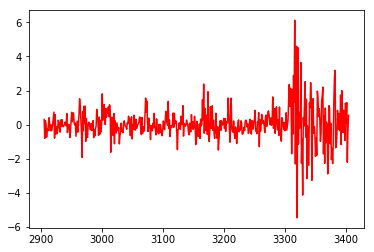

In [20]:
###################下面我们来看一下ARIMA模型
mydata=rishouyi[1:500]
plt.plot(mydata,'r-')
#plt.plot(mydata.diff(1).dropna(),'g-')

In [21]:
adf_test(mydata)########较不平稳

Test Statistic                  -5.225874
p-value                          0.000008
Lags Used                       18.000000
Number of Observations Used    480.000000
Critical Value (1%)             -3.444047
Critical Value (5%)             -2.867580
Critical Value (10%)            -2.569987
dtype: float64

In [22]:
############2阶差分之后较为平稳
def chafen(data,k):
    plt.plot(mydata.diff(k).dropna(),'g-')
    print('k阶差分效果')
    print(adf_test(mydata.diff(k).dropna()))
#如果p值显著大于0.05，统计量化大于三个或者两个水平值，差距越大，越不平稳。

#若统计量显著小于三个置信度且p值接近0，为平稳序列

#其他情况，可能是数据量不够的原因没有展现趋势

k阶差分效果
Test Statistic                -8.043686e+00
p-value                        1.818398e-12
Lags Used                      1.700000e+01
Number of Observations Used    4.790000e+02
Critical Value (1%)           -3.444076e+00
Critical Value (5%)           -2.867593e+00
Critical Value (10%)          -2.569994e+00
dtype: float64


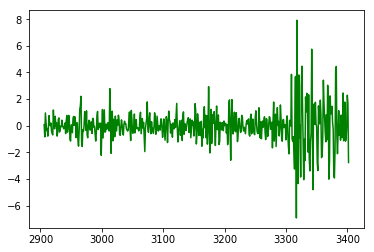

In [23]:
chafen(mydata,2)

In [24]:
def baizaosheng(D_data,k):
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(D_data, lags=k))
    # 分别为stat值（统计量）和P值
    

In [25]:
baizaosheng(mydata,2)
#P值小于0.05，所以一阶差分后的序列为平稳非白噪声序列

差分序列的白噪声检验结果为： (array([ 2.71699684, 12.26006865]), array([0.09928466, 0.00217651]))


In [26]:
def queding_pq(D_data):
    ##############确定p,q值
    
    from statsmodels.tsa.arima_model import ARIMA
    #定阶
    
    #一般阶数不超过length/10
    
    #pmax = int(len(D_data)/10) 
    pmax = 6
    #一般阶数不超过length/10
    
    #qmax = int(len(D_data)/10) 
    qmax =6
    
    #bic矩阵
    
    bic_matrix = [] 
    for p in range(pmax+1):
      tmp = []
      for q in range(qmax+1):
    #存在部分报错，所以用try来跳过报错。
        try: 
          print(ARIMA(D_data, (p,2,q)).fit().bic)
          tmp.append(ARIMA(D_data, (p,2,q)).fit().bic)
        except:
          tmp.append(100000)
      bic_matrix.append(tmp)
    
    #从中可以找出最小值
    
    bic_matrix = pd.DataFrame(bic_matrix) 
    
    #先用stack展平，然后用idxmin找出最小值位置。
    
    p,q = bic_matrix.stack().idxmin() 
    
    print(u'BIC最小的p值和q值为：%s、%s' %(p,q))
    
    # 取BIC信息量达到最小的模型阶数，结果p为0，q为1，定阶完成。

In [22]:
queding_pq(mydata)

/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

2360.150505183456
1795.4686029735738


1971.0563778247438


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1445.5962131546937


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1798.7694541990782


1773.3865639241646


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1465.907053941239


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1710.7013171885922


1505.949187293663


1704.8358632375184


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1458.8001526882915


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1639.9294598278016


1450.622606708177


BIC最小的p值和q值为：1、3


In [27]:
#################例题7.1
######我选取USB的日收益的1：500个数据进行ARIMA模型和AR模型，并编写python程序，求解这一章中提到的均方误差进行模型评估
######（注：这两个模型只是展现一下如何用python实现模型的评估，所以模型的拟合效果可能不是很好）

In [28]:
##########首先是ARIMA（1，2，3）模型
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(mydata, (1,2,3)).fit() 
print(model.summary2()) #给出一份模型报告

/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                          Results: ARIMA
Model:              ARIMA            BIC:                 1445.5962
Dependent Variable: D2.USB.Close     Log-Likelihood:      -704.17  
Date:               2020-08-07 17:50 Scale:               1.0000   
No. Observations:   497              Method:              css-mle  
Df Model:           5                Sample:              2        
Df Residuals:       492                                   9        
Converged:          1.0000           S.D. of innovations: 0.974    
No. Iterations:     44.0000          HQIC:                1430.256 
AIC:                1420.3447                                      
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               0.0000   0.0000   0.2384 0.8117 -0.0000  0.0000
ar.L1.D2.USB.Close -0.9717   0.0127 -76.4444 0.0000 -0.9966 -0.9467
ma.L1.D

In [29]:
####评估模型预测结果
test=rishouyi[500:505]
predictions = model.predict(start=len(mydata), end=len(mydata)+len(test)-1, 
                            dynamic=False,typ='levels')######有差分，要加typ='levels'
predictions=np.matrix(predictions)
test=np.matrix(test)
# print(predictions[0,1])
# print(test[0,1])
#print(test)
for i in range(5):
    #print(test[i])
    print('predicted=%f, expected=%f' ,predictions[0,i], test[0,i])

from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=%f, expected=%f -0.11808473770099881 -0.6400000000000006
predicted=%f, expected=%f 0.07833345775694289 0.5799979999999962
predicted=%f, expected=%f -0.11566732637562316 0.0
predicted=%f, expected=%f 0.06968532146040313 -0.3899990000000031
predicted=%f, expected=%f -0.11355847693377907 0.4500010000000074


Test MSE: 0.213


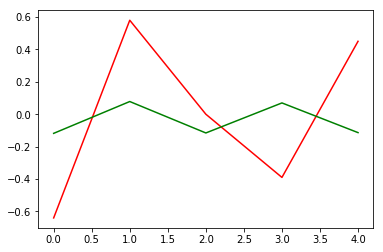

In [30]:
test=np.array(test)
predictions=np.array(predictions)
#print(test[0:1])
plt.plot(test[0,:],'r-')
plt.plot(predictions[0,:],'g-')

In [31]:
############接着，使用AR（2）模型
from statsmodels.tsa.arima_model import ARIMA,ARMA
ar_2= ARMA(rishouyi[1:500], order=(2,0)).fit(disp=-1)
print(ar_2.summary2()) #给出一份模型报告


                           Results: ARMA
Model:              ARMA             BIC:                 1407.8527
Dependent Variable: USB.Close        Log-Likelihood:      -691.50  
Date:               2020-08-07 17:51 Scale:               1.0000   
No. Observations:   499              Method:              css-mle  
Df Model:           3                Sample:              0        
Df Residuals:       496                                   9        
Converged:          1.0000           S.D. of innovations: 0.967    
No. Iterations:     8.0000           HQIC:                1397.615 
AIC:                1391.0023                                      
--------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
--------------------------------------------------------------------
const             0.0300    0.0465   0.6442  0.5197  -0.0612  0.1211
ar.L1.USB.Close  -0.0638    0.0443  -1.4393  0.1507  -0.1507  0.0231
ar

/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

In [32]:
######对AR（2）模型的预测结果进行评估
test=rishouyi[500:505]
predictions_ar2 = ar_2.predict(start=len(mydata), end=len(mydata)+len(test)-1, 
                               dynamic=False)
predictions_ar2=np.matrix(predictions_ar2)
test=np.matrix(test)
# print(predictions[0,1])
# print(test[0,1])
#print(test)
for i in range(5):
    #print(test[i])
    print('predicted_ar2=%f, expected=%f' ,predictions_ar2[0,i], test[0,i])

from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions_ar2)
print('Test MSE: %.3f' % error)

predicted_ar2=%f, expected=%f -0.09890011862292097 -0.6400000000000006
predicted_ar2=%f, expected=%f 0.07406466928593247 0.5799979999999962
predicted_ar2=%f, expected=%f 0.010017302830095685 0.0
predicted_ar2=%f, expected=%f 0.03708994069699921 -0.3899990000000031
predicted_ar2=%f, expected=%f 0.026851064293955507 0.4500010000000074
Test MSE: 0.182


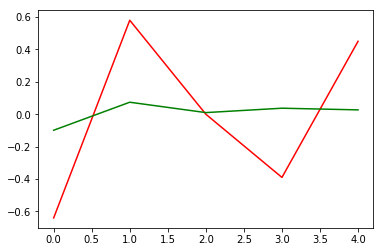

In [33]:
test=np.array(test)
predictions_ar2=np.array(predictions_ar2)
#print(test[0:1])
plt.plot(test[0,:],'r-')
plt.plot(predictions_ar2[0,:],'g-')

In [34]:
###########结论：从MSE可以看出，对于所选取的数据，AR（2）模型要优于ARIMA（1，2，3）



In [35]:

##########例题7.2是对一个ARIMA(0,1,3)模型的评估分析，调用的python函数与例题7.1相同，由于没有相应的数据，就不再重复实现
#例题7.3是对一个错误指定的模型的分析 无python代码

In [36]:
##########例题8.1是对All Share index的ARIMA（2，1，2）的一个分析，下面，我将使用USB的前500个收盘价数据寻找其合适的ARIMA模型并进行模型预测评估
####首先我们获取数据
exp_8_1_data=Close[1:500]

In [37]:
#####然后我们对数据进行直观分析
#####定义数据直观分析函数
def SimAnlysis_ts(ts, w):
    roll_mean = ts.rolling(window = w).mean()#w个数据为一个窗口，取均值
    roll_std = ts.rolling(window = w).std()  #取方差
    pd_ewma = ts.ewm(span=w).mean()# # 指数平均线。ts：数据；span：时间间隔

    plt.clf()
    plt.figure()
    plt.grid()
    plt.plot(ts, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.plot(pd_ewma, color='yellow', label = 'EWMA')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')##滑动平均值和标准偏差
    plt.show()
    #plt.savefig('./图片/'+title+'.pdf', format='pdf')

<Figure size 432x288 with 0 Axes>

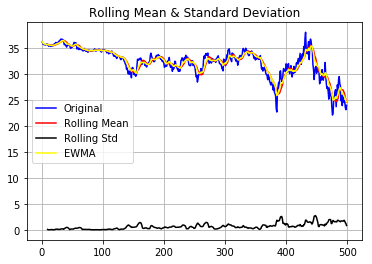

In [38]:
#####然后我们直观分析选用的数据
SimAnlysis_ts(exp_8_1_data, 10)
#####可以看出，这是一个非平稳的时间序列

In [39]:
######现在，我想寻找差分阶数
#####定义差分效果函数
def chafen(data,k):
    plt.plot(mydata.diff(k).dropna(),'g-')
    print('k阶差分效果')
    print(adf_test(mydata.diff(k).dropna()))
#如果p值显著大于0.05，统计量化大于三个或者两个水平值，差距越大，越不平稳。
#若统计量显著小于三个置信度且p值接近0，为平稳序列
#其他情况，可能是数据量不够的原因没有展现趋势


k阶差分效果
Test Statistic                -7.734457e+00
p-value                        1.103128e-11
Lags Used                      1.700000e+01
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


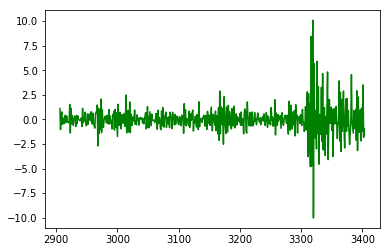

In [40]:
chafen(exp_8_1_data,1)
#######从图中可以看出，一阶差分之后，差分效果有了很明显的提升，同时，p值接近0

In [41]:
#########下面，我们寻找ARIMA的p,q
#######定义p,q寻找函数,原理是求得取BIC信息量达到最小的模型阶数(默认是1阶差分)
def queding_pq(D_data):
    ##############确定p,q值
    
    from statsmodels.tsa.arima_model import ARIMA
    #定阶
    
    #一般阶数不超过length/10
    
    #pmax = int(len(D_data)/10) 
    pmax = 6
    #一般阶数不超过length/10
    
    #qmax = int(len(D_data)/10) 
    qmax =6
    
    #bic矩阵
    
    bic_matrix = [] 
    for p in range(pmax+1):
      tmp = []
      for q in range(qmax+1):
    #存在部分报错，所以用try来跳过报错。
        try: 
          print(ARIMA(D_data, (p,1,q)).fit().bic)
          tmp.append(ARIMA(D_data, (p,1,q)).fit().bic)
        except:
          tmp.append(100000)
      bic_matrix.append(tmp)
    
    #从中可以找出最小值
    
    bic_matrix = pd.DataFrame(bic_matrix) 
    
    #先用stack展平，然后用idxmin找出最小值位置。
    
    p,q = bic_matrix.stack().idxmin() 
    
    print(u'BIC最小的p值和q值为：%s、%s' %(p,q))
    
    # 取BIC信息量达到最小的模型阶数。

In [42]:
queding_pq(exp_8_1_data)

/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

1261.0012933556998
1253.9713171466638


1253.40497514352
1259.5975475547405


1263.6643812598963


1269.7701689963017


1274.8962875929765


1257.1012169559021
1253.169760364578


1259.2961182799465


1255.2608774173384


1259.3252208119852


1265.0254022744732


1261.1840200216523


1259.96054802585


1269.3314089650244


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1273.0341974599824


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


1264.2690989801483


1270.0246204829305


1275.5214286861717


1267.5665370439197


1270.3564778227897


1276.235210293071


1276.078930777221


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1284.442152740725


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


1274.097189017608


1279.488187693548


1273.0414832268489


1279.0241088580385


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


nan


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


BIC最小的p值和q值为：1、1


In [43]:
##########所以确定是ARIMA（1，1，1）模型
from statsmodels.tsa.arima_model import ARIMA
model_8_1 = ARIMA(exp_8_1_data, (1,1,1)).fit() 
print(model_8_1.summary2()) #给出一份模型报告

                          Results: ARIMA
Model:              ARIMA            BIC:                 1253.1698
Dependent Variable: D.USB.Close      Log-Likelihood:      -614.16  
Date:               2020-08-07 17:51 Scale:               1.0000   
No. Observations:   498              Method:              css-mle  
Df Model:           3                Sample:              1        
Df Residuals:       495                                   9        
Converged:          1.0000           S.D. of innovations: 0.830    
No. Iterations:     17.0000          HQIC:                1242.937 
AIC:                1236.3274                                      
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               -0.0241   0.0237 -1.0149 0.3107 -0.0705  0.0224
ar.L1.D.USB.Close    0.5240   0.1547  3.3866 0.0008  0.2208  0.8273
ma.L1.D

In [44]:
######对ARIMA（1，1，1）模型的预测结果进行评估
test_81=Close[500:505]
predictions__81 = model_8_1.predict(start=len(exp_8_1_data), 
                                    end=len(exp_8_1_data)+len(test_81)-1, dynamic=False,
                                    typ='levels')
predictions__81=np.matrix(predictions__81)
test_81=np.matrix(test_81)
# print(predictions[0,1])
# print(test[0,1])
#print(test)
for i in range(5):
    #print(test[i])
    print('predicted_81=%f, expected=%f' ,predictions__81[0,i], test_81[0,i])

from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_81, predictions__81)
print('Test_81 MSE: %.3f' % error)

predicted_81=%f, expected=%f 23.99280369670552 24.25
predicted_81=%f, expected=%f 23.982817672827352 23.709999
predicted_81=%f, expected=%f 23.96612928396315 24.110001
predicted_81=%f, expected=%f 23.94592856688879 25.01
predicted_81=%f, expected=%f 23.923887238406138 25.25
Test_81 MSE: 0.610


In [45]:
###########例题8.2实现的是用H-P trend filter获取全球气温趋势，下面，我们直接使用datasets模块自带的数据集进行GDP趋势获取
import statsmodels.api as sm
nt=sm.datasets.macrodata.NOTE#datasets模块包含了很多数据集，我们在这里调用macrodata这个数据集，然后查看这个数据集的相关信息

In [46]:
######首先载入数据集
df=sm.datasets.macrodata.load_pandas().data
print(df.head())

     year  quarter   realgdp  realcons  realinv  realgovt  realdpi    cpi  \
0  1959.0      1.0  2710.349    1707.4  286.898   470.045   1886.9  28.98   
1  1959.0      2.0  2778.801    1733.7  310.859   481.301   1919.7  29.15   
2  1959.0      3.0  2775.488    1751.8  289.226   491.260   1916.4  29.35   
3  1959.0      4.0  2785.204    1753.7  299.356   484.052   1931.3  29.37   
4  1960.0      1.0  2847.699    1770.5  331.722   462.199   1955.5  29.54   

      m1  tbilrate  unemp      pop  infl  realint  
0  139.7      2.82    5.8  177.146  0.00     0.00  
1  141.7      3.08    5.1  177.830  2.34     0.74  
2  140.5      3.82    5.3  178.657  2.74     1.09  
3  140.0      4.33    5.6  179.386  0.27     4.06  
4  139.6      3.50    5.2  180.007  2.31     1.19  


In [47]:
######重新定义日期
index=pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
df.index=index

In [48]:
######在这里，我们使用H-P trend filter
gdp_cyclical, gdp_trend=sm.tsa.filters.hpfilter(df['realgdp'])
print(gdp_trend.head())

1959-03-31    2670.837085
1959-06-30    2698.712468
1959-09-30    2726.612545
1959-12-31    2754.612067
1960-03-31    2782.816333
Name: realgdp, dtype: float64


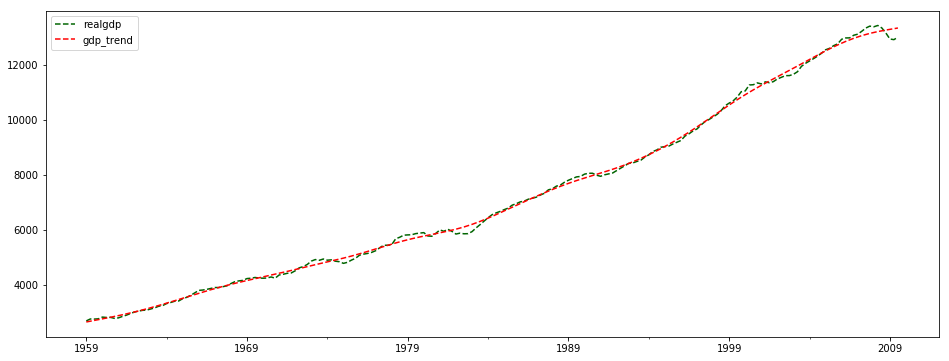

In [49]:
########下面，我们将趋势和原数据一起作图
df['gdp_trend']=gdp_trend
df['gdp_cyclical']=gdp_cyclical
df[['realgdp', 'gdp_trend']].plot(figsize=(16, 6), color=['darkgreen', 'red'], linestyle='dashed')
########可以看出，趋势与数据符合的相当的不错！

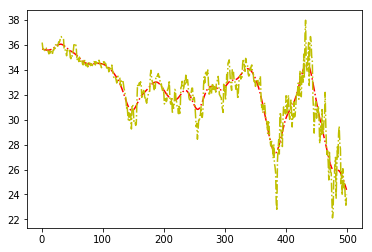

In [50]:
######例题8.2使用了H-p filter 获取了英国实际人均对数的趋势，由于我们没有数据，所以，我们使用USB的收盘价1：500数据试一下
######使用USB的收盘价1：500数据试一下
cyclical, trend=sm.tsa.filters.hpfilter(exp_8_1_data)#######获得的是周期项和趋势项
plt.plot(trend,'r-.')
plt.plot(exp_8_1_data,'y-.')
#######可以看出，趋势与我们的数据符合的比较好！

In [51]:
#######例题9.1 确定性季节性模型(季节性模式是确定的，可以通过绘图看出季节性模式是天，周月，还是季度)
#######下面使用的是大气的CO2月度数据（1959年1月至1987年12月）
# 该在整个样本中都有明显的趋势和季节性。
co2 = [315.58, 316.39, 316.79, 317.82, 318.39, 318.22, 316.68, 315.01, 314.02, 313.55,
       315.02, 315.75, 316.52, 317.10, 317.79, 319.22, 320.08, 319.70, 318.27, 315.99,
       314.24, 314.05, 315.05, 316.23, 316.92, 317.76, 318.54, 319.49, 320.64, 319.85,
       318.70, 316.96, 315.17, 315.47, 316.19, 317.17, 318.12, 318.72, 319.79, 320.68,
       321.28, 320.89, 319.79, 317.56, 316.46, 315.59, 316.85, 317.87, 318.87, 319.25,
       320.13, 321.49, 322.34, 321.62, 319.85, 317.87, 316.36, 316.24, 317.13, 318.46,
       319.57, 320.23, 320.89, 321.54, 322.20, 321.90, 320.42, 318.60, 316.73, 317.15,
       317.94, 318.91, 319.73, 320.78, 321.23, 322.49, 322.59, 322.35, 321.61, 319.24,
       318.23, 317.76, 319.36, 319.50, 320.35, 321.40, 322.22, 323.45, 323.80, 323.50,
       322.16, 320.09, 318.26, 317.66, 319.47, 320.70, 322.06, 322.23, 322.78, 324.10,
       324.63, 323.79, 322.34, 320.73, 319.00, 318.99, 320.41, 321.68, 322.30, 322.89,
       323.59, 324.65, 325.30, 325.15, 323.88, 321.80, 319.99, 319.86, 320.88, 322.36,
       323.59, 324.23, 325.34, 326.33, 327.03, 326.24, 325.39, 323.16, 321.87, 321.31,
       322.34, 323.74, 324.61, 325.58, 326.55, 327.81, 327.82, 327.53, 326.29, 324.66,
       323.12, 323.09, 324.01, 325.10, 326.12, 326.62, 327.16, 327.94, 329.15, 328.79,
       327.53, 325.65, 323.60, 323.78, 325.13, 326.26, 326.93, 327.84, 327.96, 329.93,
       330.25, 329.24, 328.13, 326.42, 324.97, 325.29, 326.56, 327.73, 328.73, 329.70,
       330.46, 331.70, 332.66, 332.22, 331.02, 329.39, 327.58, 327.27, 328.30, 328.81,
       329.44, 330.89, 331.62, 332.85, 333.29, 332.44, 331.35, 329.58, 327.58, 327.55,
       328.56, 329.73, 330.45, 330.98, 331.63, 332.88, 333.63, 333.53, 331.90, 330.08,
       328.59, 328.31, 329.44, 330.64, 331.62, 332.45, 333.36, 334.46, 334.84, 334.29,
       333.04, 330.88, 329.23, 328.83, 330.18, 331.50, 332.80, 333.22, 334.54, 335.82,
       336.45, 335.97, 334.65, 332.40, 331.28, 330.73, 332.05, 333.54, 334.65, 335.06,
       336.32, 337.39, 337.66, 337.56, 336.24, 334.39, 332.43, 332.22, 333.61, 334.78,
       335.88, 336.43, 337.61, 338.53, 339.06, 338.92, 337.39, 335.72, 333.64, 333.65,
       335.07, 336.53, 337.82, 338.19, 339.89, 340.56, 341.22, 340.92, 339.26, 337.27,
       335.66, 335.54, 336.71, 337.79, 338.79, 340.06, 340.93, 342.02, 342.65, 341.80,
       340.01, 337.94, 336.17, 336.28, 337.76, 339.05, 340.18, 341.04, 342.16, 343.01,
       343.64, 342.91, 341.72, 339.52, 337.75, 337.68, 339.14, 340.37, 341.32, 342.45,
       343.05, 344.91, 345.77, 345.30, 343.98, 342.41, 339.89, 340.03, 341.19, 342.87,
       343.74, 344.55, 345.28, 347.00, 347.37, 346.74, 345.36, 343.19, 340.97, 341.20,
       342.76, 343.96, 344.82, 345.82, 347.24, 348.09, 348.66, 347.90, 346.27, 344.21,
       342.88, 342.58, 343.99, 345.31, 345.98, 346.72, 347.63, 349.24, 349.83, 349.10,
       347.52, 345.43, 344.48, 343.89, 345.29, 346.54, 347.66, 348.07, 349.12, 350.55,
       351.34, 350.80, 349.10, 347.54, 346.20, 346.20, 347.44, 348.67]
#####添加日期
co2 = pd.Series(co2, index=pd.date_range('1-1-1959', periods=len(co2), freq='M'), name = 'CO2')
co2.describe()####看看数据的统计情况

count    348.000000
mean     330.123879
std       10.059747
min      313.550000
25%      321.302500
50%      328.820000
75%      338.002500
max      351.340000
Name: CO2, dtype: float64

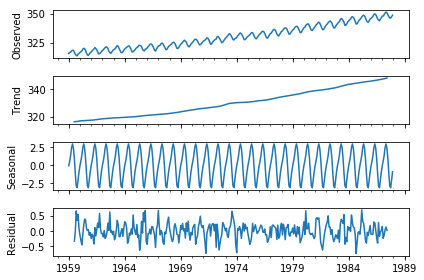

In [52]:
######我们使用季节性分解命令，画图看一下季节性趋势
from statsmodels.tsa.seasonal import seasonal_decompose
stl = seasonal_decompose(co2)

fig = stl.plot()
######我们可以看出，CO2的季节性趋势非常明显，也就是一个确定性的季节性模型

            riders
month             
1973-01-01     648
1973-02-01     646
1973-03-01     639
1973-04-01     654
1973-05-01     630


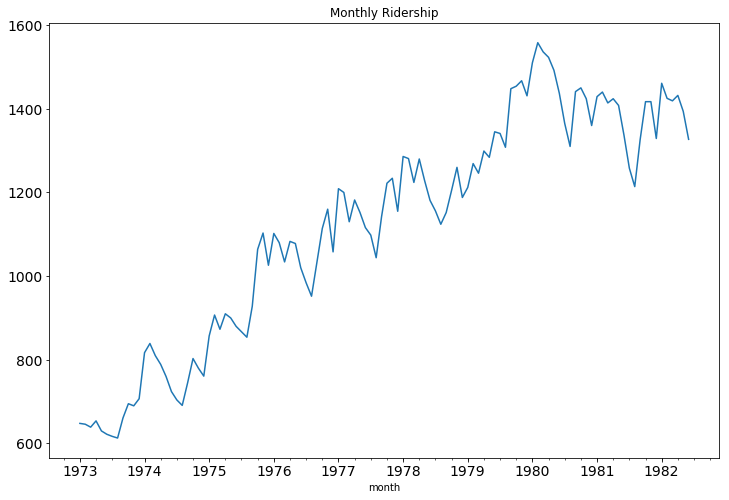

In [53]:
#######例题9.2实现的是一个啤酒销量的季节性ARIMA建模,由于无法获取数据，我将采用
#########波特兰公共交通系统的每月乘客数量数据进行ARIMA建模并进行预测和评价
###########首先导入数据，简单观察一下数据并进行可视化
%matplotlib inline
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
 
df = pd.read_csv('/home/yinaihua/Desktop/时间序列/期末作业/chapter-07/file/portland-oregon-average-monthly.csv',
                 parse_dates=['month'], index_col='month')
print(df.head())
df['riders'].plot(figsize=(12,8), title= 'Monthly Ridership', fontsize=14)
plt.savefig('month_ridership.png', bbox_inches='tight')



<Figure size 432x288 with 0 Axes>

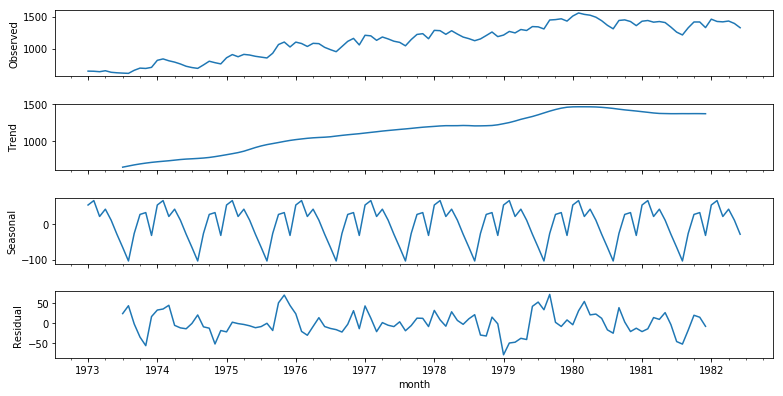

In [54]:
#########然后我们分解数据
decomposition = seasonal_decompose(df['riders'], freq=12)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

In [55]:
########编写函数测试一下时间序列是否稳定（这个在前面ARIMA建模中已经写过，稍有不同）
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
 
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

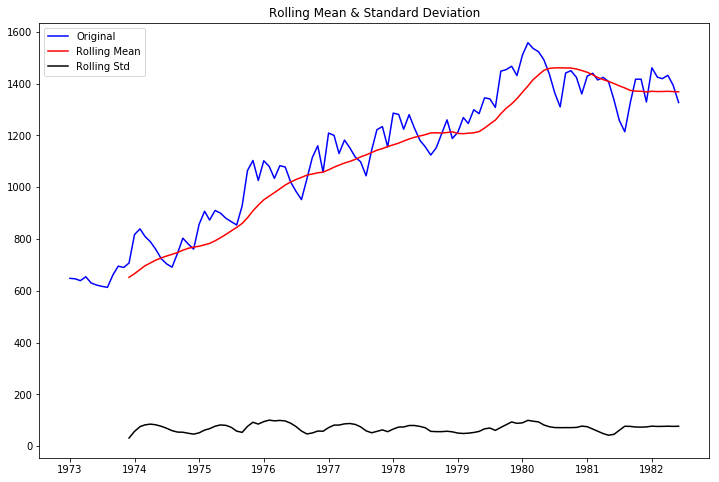

Results of Dickey-Fuller Test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [56]:
########我们测试一下稳定性
test_stationarity(df['riders'])
########从p值大于0.5和t统计量大于三个Critical Value可以得出，整体的序列并没有到达稳定性要求

In [57]:
#######要将时间序列转为平稳序列，有如下几种方法：
#Deflation by CPI
#Logarithmic（取对数）
#First Difference（一阶差分）
#Seasonal Difference（季节差分）
#Seasonal Adjustment

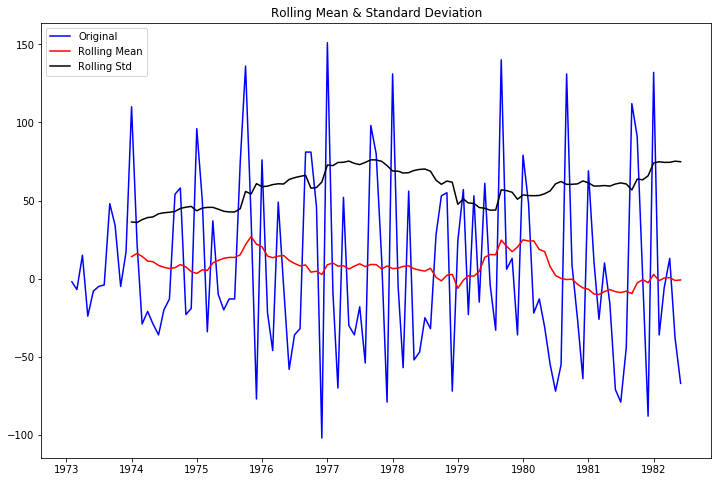

Results of Dickey-Fuller Test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [58]:
#########我们先进行一阶差分
df['first_difference'] = df['riders'].diff(1)  
test_stationarity(df['first_difference'].dropna(inplace=False))


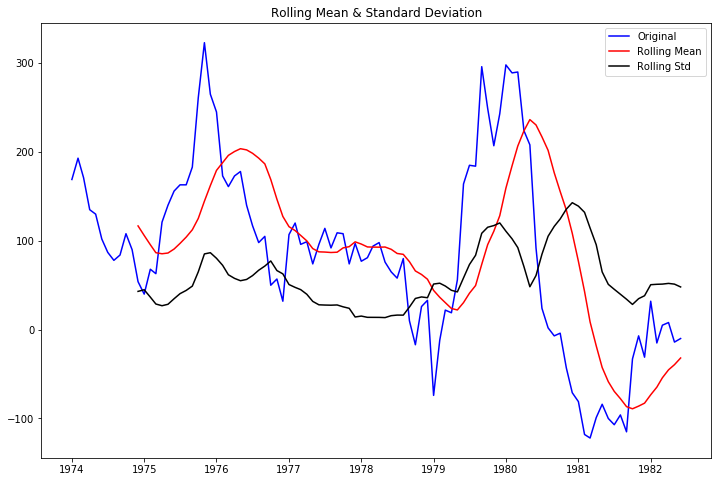

Results of Dickey-Fuller Test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (1%)            -3.498910
Critical Value (5%)            -2.891516
Critical Value (10%)           -2.582760
dtype: float64


In [59]:
##################可以看到图形上看上去变稳定了，但p-value的并没有小于0.05
###############再来看一下12阶查分（即季节查分）
df['seasonal_difference'] = df['riders'].diff(12)  
test_stationarity(df['seasonal_difference'].dropna(inplace=False))
#####从图形上，比一阶差分更不稳定（虽然季节指标已经出来了）


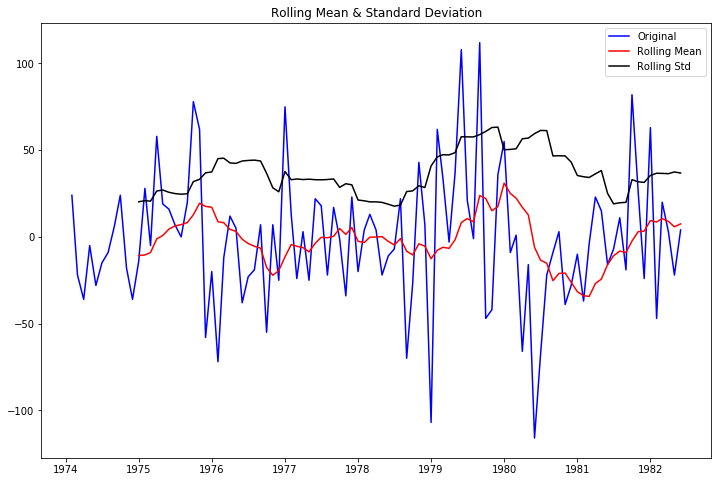

Results of Dickey-Fuller Test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [60]:
#我们再来将一阶查分和季节查分合并起来，再来看下
df['seasonal_first_difference'] = df['first_difference'].diff(12)  
test_stationarity(df['seasonal_first_difference'].dropna(inplace=False))
####可以看到，在一阶差分后再加上季节差分，数据终于稳定下了。P-value小于了0.05
#并且Test Statistic的值远远小于Critical Value (5%)的值。

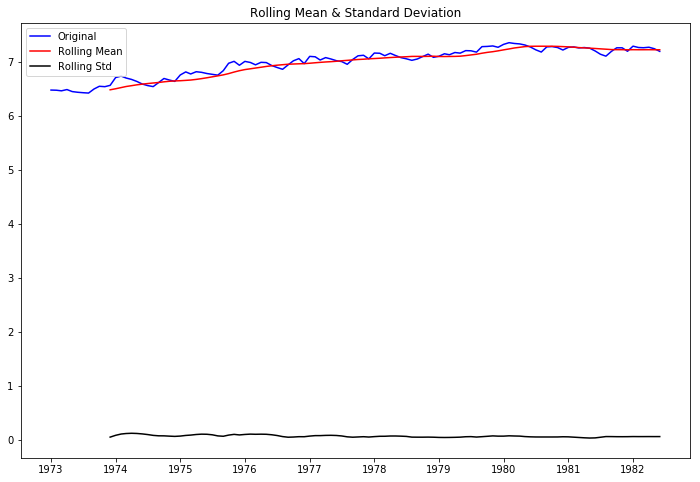

Results of Dickey-Fuller Test:
Test Statistic                  -1.677830
p-value                          0.442570
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [61]:
###############在《Analysis of Financial Time Series》提到，对原始数据取对数有两个用处：
# 第一个是将指数增长转为线性增长；
# 第二可以平稳序列的方差。
# 所以再来看看取对数的数据
df['riders_log']= np.log(df['riders'])
test_stationarity(df['riders_log'])

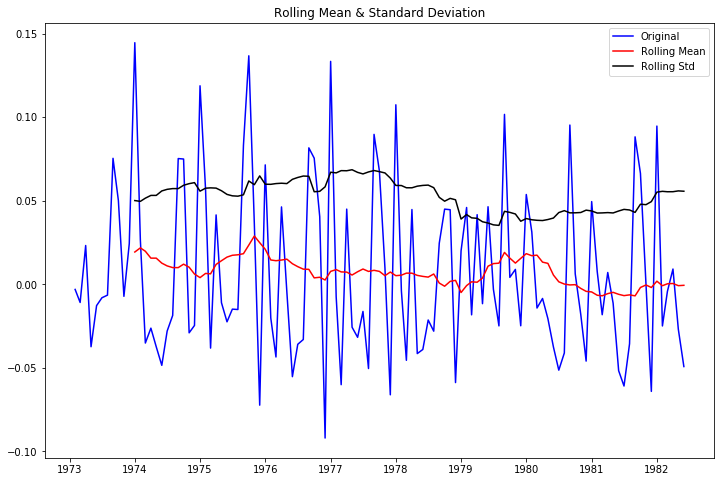

Results of Dickey-Fuller Test:
Test Statistic                  -2.047539
p-value                          0.266126
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [62]:
###########取对数后，从图形上看有些稳定了，但p-value还是没有接近0.05，没能达稳定性要求。
# 在此基础上我们再来做下一阶差分，去除增长趋势：
df['log_first_difference'] = df['riders_log'].diff(1)  
test_stationarity(df['log_first_difference'].dropna(inplace=False))
##还是没能满足需求，我们再来对对数进行季节性差分：

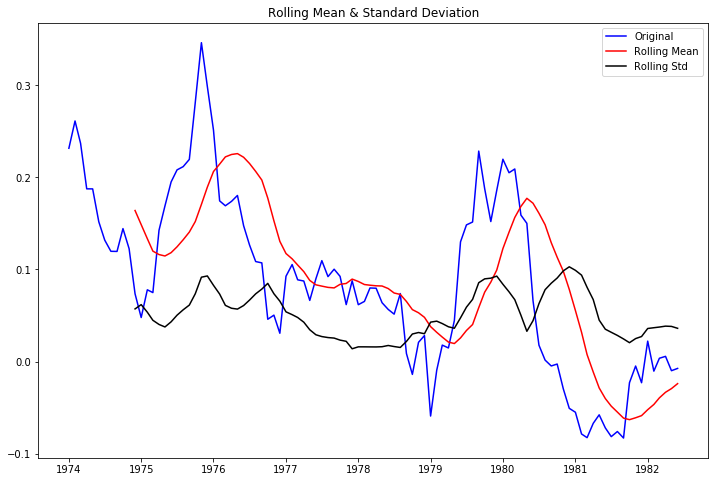

Results of Dickey-Fuller Test:
Test Statistic                  -1.919681
p-value                          0.322860
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


In [63]:
df['log_seasonal_difference'] = df['riders_log'].diff(12)  
test_stationarity(df['log_seasonal_difference'].dropna(inplace=False))
#####还是没能满足需求

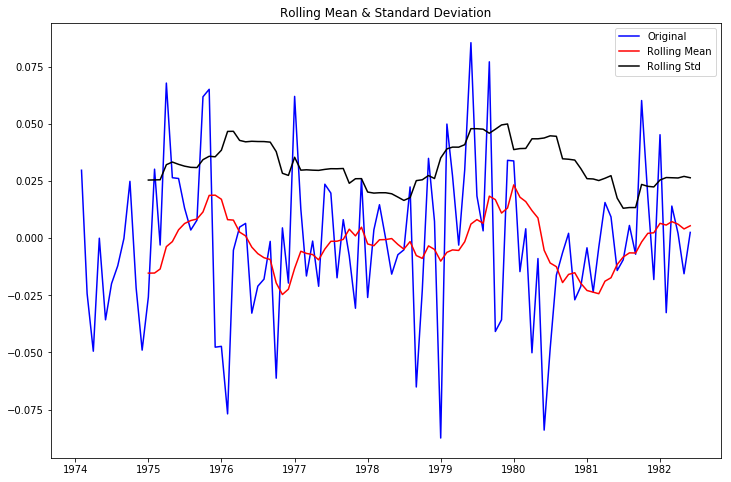

Results of Dickey-Fuller Test:
Test Statistic                -8.882112e+00
p-value                        1.309452e-14
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (1%)           -3.497501e+00
Critical Value (5%)           -2.890906e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [64]:
#####再来试试在对数基础上进行一阶差分+季节差分的效果:
df['log_seasonal_first_difference'] = df['log_first_difference'].diff(12)  
test_stationarity(df['log_seasonal_first_difference'].dropna(inplace=False))
########可以看到稳定了满足需求了，但是稳定性相比不取对数的情况下，并没有提升而是下降了。

/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


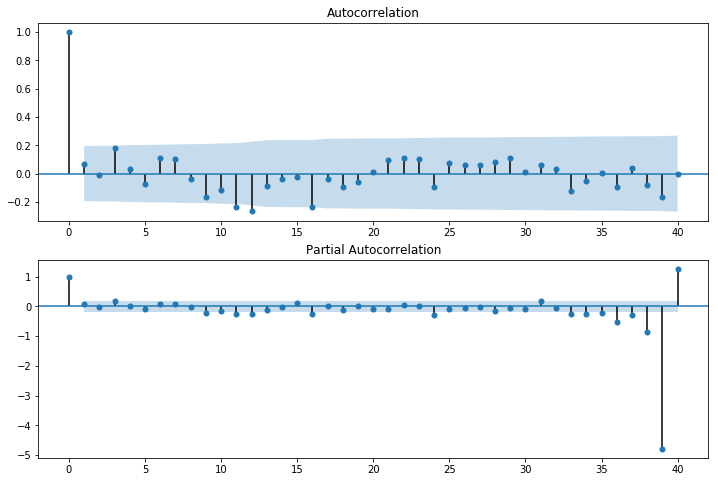

In [65]:
#######下面我们绘制ACF和PACF图，找出最佳参数(具体怎么看？？？)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['seasonal_first_difference'].iloc[13:], lags=40, ax=ax1) #从13开始是因为做季节性差分时window是12
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['seasonal_first_difference'].iloc[13:], lags=40, ax=ax2)


In [145]:
########创建模型并进行预测
mod = sm.tsa.statespace.SARIMAX(df['riders'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -501.340
Date:                            Fri, 07 Aug 2020   AIC                           1008.680
Time:                                    17:02:23   BIC                           1016.526
Sample:                                01-01-1973   HQIC                          1011.856
                                     - 06-01-1982                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3236      0.186      1.739      0.082      -0.041       0.688
ma.S.L12      -0.9990     42.039   

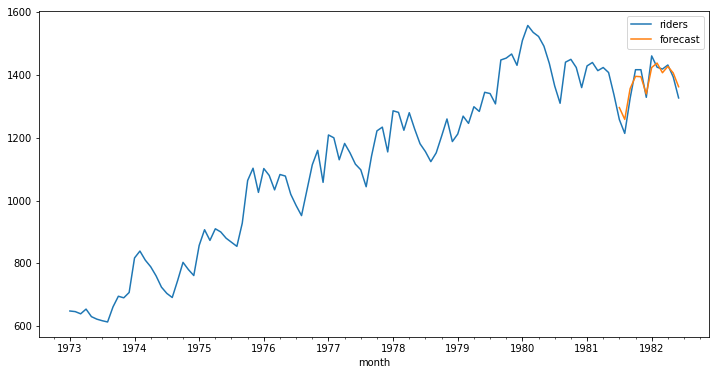

In [146]:
#########预测值与真实值比较：
df['forecast'] = results.predict(start = 102, end= 114, dynamic= True)  
df[['riders', 'forecast']].plot(figsize=(12, 6)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

/home/yinaihua/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/yinaihua/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


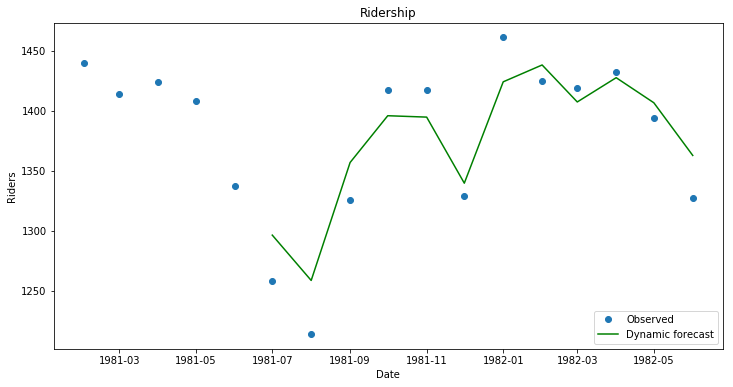

In [147]:
npredict =df['riders']['1982'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Ridership', xlabel='Date', ylabel='Riders')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'riders'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], df.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')
# plt.savefig('ts_predict_compare.png', bbox_inches='tight')

In [148]:
########为了产生针对未来的预测值，我们加入新的时间
start = datetime.datetime.strptime("1982-07-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df.columns)
df = pd.concat([df, future])

/home/yinaihua/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


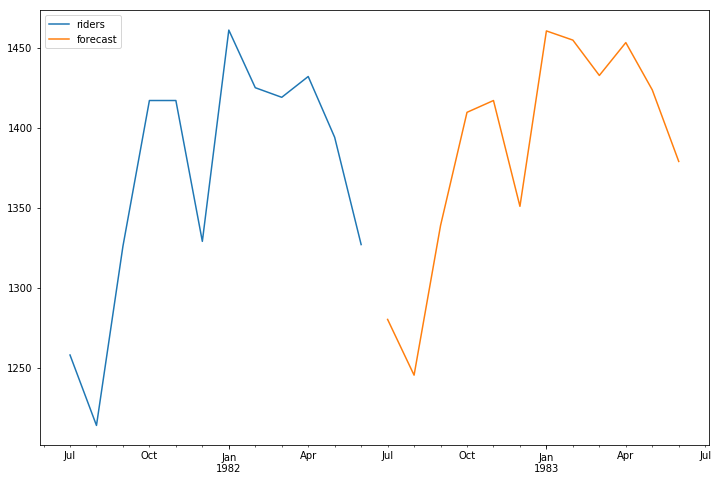

In [149]:
########在新加入的时间上来预测未来值并绘图：
df['forecast'] = results.predict(start = 114, end = 125, dynamic= True)  
df[['riders', 'forecast']].ix[-24:].plot(figsize=(12, 8)) 
#plt.savefig('ts_predict_future.png', bbox_inches='tight')


In [150]:
########在例题9.3中使用简单指数平滑预测全球气温,并说明简单指数平滑是最优预测方法。同时使用RMSE进行预测评价
########由于我们没有数据，所以，我使用的是Hyndman和Athanasopoulos [1]关于指数平滑的优秀论文的第七章中的相关数据
# （比较适合指数平滑模型）
###############首先，我们加载一下数据：
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline

data = [446.6565,  454.4733,  455.663 ,  423.6322,  456.2713,  440.5881, 425.3325,  485.1494,  506.0482,  526.792 ,  514.2689,  494.211 ]
index= pd.date_range(start='1996', end='2008', freq='A')
oildata = pd.Series(data, index)

data = [17.5534,  21.86  ,  23.8866,  26.9293,  26.8885,  28.8314, 30.0751,  30.9535,  30.1857,  31.5797,  32.5776,  33.4774, 39.0216,  41.3864,  41.5966]
index= pd.date_range(start='1990', end='2005', freq='A')
air = pd.Series(data, index)

data = [263.9177,  268.3072,  260.6626,  266.6394,  277.5158,  283.834 , 290.309 ,  292.4742,  300.8307,  309.2867,  318.3311,  329.3724, 338.884 ,  339.2441,  328.6006,  314.2554,  314.4597,  321.4138, 329.7893,  346.3852,  352.2979,  348.3705,  417.5629,  417.1236, 417.7495,  412.2339,  411.9468,  394.6971,  401.4993,  408.2705, 414.2428]
index= pd.date_range(start='1970', end='2001', freq='A')
livestock2 = pd.Series(data, index)

data = [407.9979 ,  403.4608,  413.8249,  428.105 ,  445.3387,  452.9942, 455.7402]
index= pd.date_range(start='2001', end='2008', freq='A')
livestock3 = pd.Series(data, index)

data = [41.7275,  24.0418,  32.3281,  37.3287,  46.2132,  29.3463, 36.4829,  42.9777,  48.9015,  31.1802,  37.7179,  40.4202, 51.2069,  31.8872,  40.9783,  43.7725,  55.5586,  33.8509, 42.0764,  45.6423,  59.7668,  35.1919,  44.3197,  47.9137]
index= pd.date_range(start='2005', end='2010-Q4', freq='QS-OCT')
aust = pd.Series(data, index)

Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.


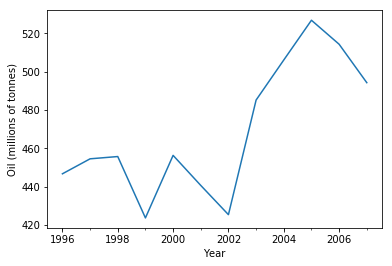

In [151]:
###########让我们使用“简单指数平滑”来预测以下油的数据
################首先，可视化数据
ax=oildata.plot()
ax.set_xlabel("Year")
ax.set_ylabel("Oil (millions of tonnes)")
print("Figure 7.1: Oil production in Saudi Arabia from 1996 to 2007.")

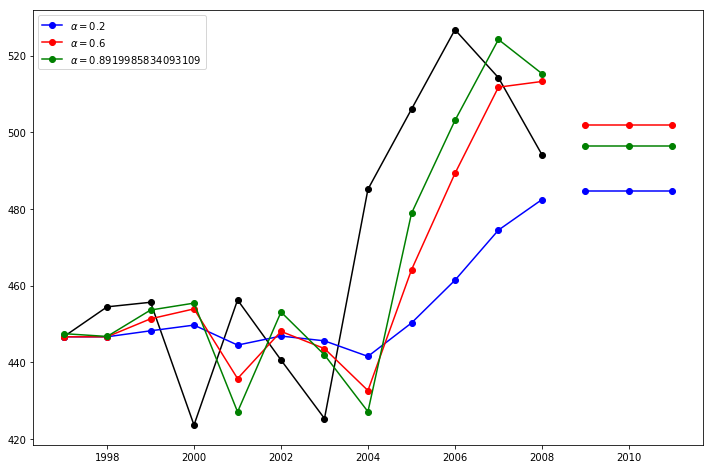

In [152]:
###########接下来，我们将实现三种简单的指数平滑方法来实现对油数据的预测
#1. fit1不使用自动优化，而是选择显式地为模型提供α=0.2
#2.fit2选择一个α=0.63
#fit3我们允许statsmodels自动找到优化的α对我们有价值。这是推荐的方法(省时省力)
fit1 = SimpleExpSmoothing(oildata).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(3).rename(r'$\alpha=0.2$')
fit2 = SimpleExpSmoothing(oildata).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(3).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(oildata).fit()
fcast3 = fit3.forecast(3).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

plt.figure(figsize=(12, 8))
plt.plot(oildata, marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [66]:
########例题9.4是一个Holt-Winters季节性预测模型,这是一个它是一种三次指数平滑预测，
########其背后的理念就是除了水平和趋势外，还将指数平滑应用到季节分量上
##########方程见H-W季节性ARIMA建模方程,帖子https://www.biaodianfu.com/python-time-series-forecasting-methods.html
############下面我们使用JetRail高铁的乘客数量(这个季节性比较明显的数据）进行Holt-Winters季节性预测模型建模


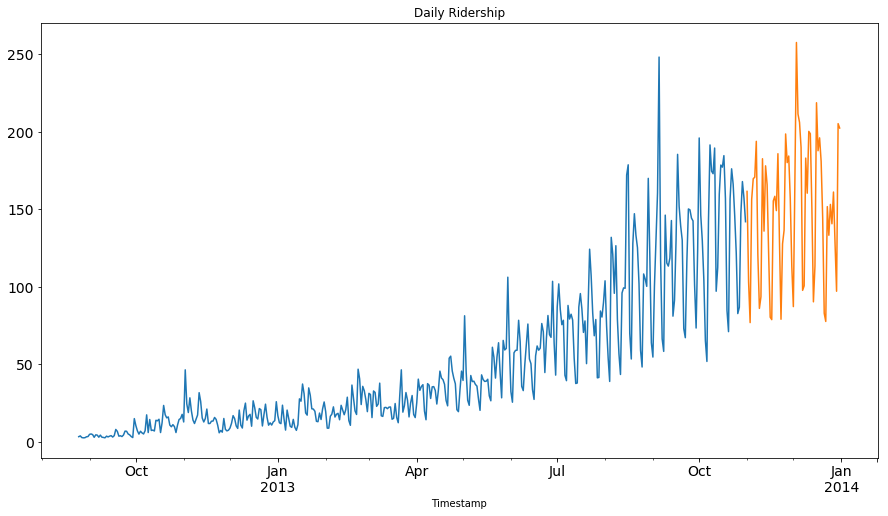

In [123]:
###########创建数据集合并可视化一下
import pandas as pd
import matplotlib.pyplot as plt
 
# Subsetting the dataset
# Index 11856 marks the end of year 2013
df = pd.read_csv('/home/yinaihua/Desktop/时间序列/期末作业/chapter-07/file/train.csv', nrows=11856)
 
# Creating train and test set
# Index 10392 marks the end of October 2013
train = df[0:10392]
test = df[10392:]
 
# 以天为单位生成数据集
df['Timestamp'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df.index = df['Timestamp']
df = df.resample('D').mean()
 
train['Timestamp'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')
train.index = train['Timestamp']
train = train.resample('D').mean()
 
test['Timestamp'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
test.index = test['Timestamp']
test = test.resample('D').mean()
 
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

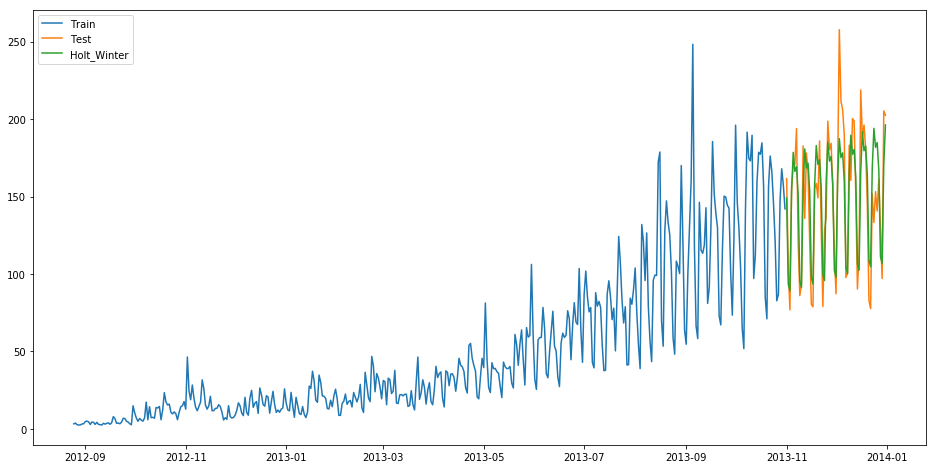

In [124]:
from statsmodels.tsa.api import ExponentialSmoothing
 
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']), 
                            seasonal_periods=7, 
                            trend='add', 
                            seasonal='add', ).fit()
                        ####seasonal_periods=7作为每周重复的数据
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16, 8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [125]:
#######测试预测结果（使用均方误差）
from sklearn.metrics import mean_squared_error
from math import sqrt
 
rms = sqrt(mean_squared_error(test['Count'], y_hat_avg['Holt_Winter']))
print(rms)
######我们看出，季节性的预测度较高

23.961492566159794


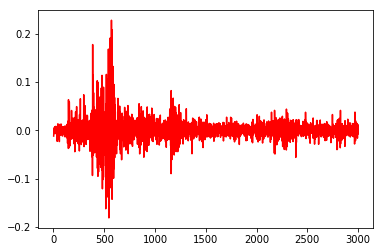

In [67]:
###########例题10.1 美元汇率的GARCH模型
###############下面，我试着用USB的收盘价涨跌幅数据实现一下GARCH模型
df=Close[1:3000]
data=(df/df.shift(1)-1).dropna()
data.name='USB收盘价涨跌幅'
plt.plot(data,'r-')

In [71]:
####注：由于jupyter notebook调用arch包失败，所以，下面的代码直接在python console中运行即可（提前配置好环境）
from arch import arch_model
garch=arch_model(y=data,mean='Constant',lags=0,vol='GARCH',p=1,o=0,q=1,dist='normal')
garchmodel=garch.fit()
garchmodel.params
garchmodel.plot()
####结果保存在   GARCH_1.png
#########可以看到GARCH(1,1)模型的参数ω=0.00000298，α=0.1，β=0.88，
# 因此模型表达式为σn2=0.00000298+0.1(un-1)2+0.88(σn-1)2

In [ ]:
############面计算长期波动率，即√VL
vol=np.sqrt(garchmodel.params[1]/(1-garchmodel.params[2]-garchmodel.params[3]))
#vol
#Out[10]: 0.012212037954677738

In [ ]:
#######例题10.2  使用10.1的模型进行预测
u30=data[-30:]
u30=np.matrix(u30)
vol302=np.zeros(30)
vol302[0]=data[-34:-29].std()#5日MA估计11月19号的波动率
for i in range(29):
    vol302[i+1]=np.sqrt(0.00000298+0.1*u30[0,i]**2+0.88*vol302[i]**2)
####计算日期
plt.plot(vol302,label='GARCH(1,1)')
##########图片见GARCH_2

In [ ]:
##########例题11.1  根据10.1得到的模型分析是否具有双线性，无python代码

In [ ]:
##########例题11.2   黑子数据建模 

In [ ]:
#######首先导入相关包
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot

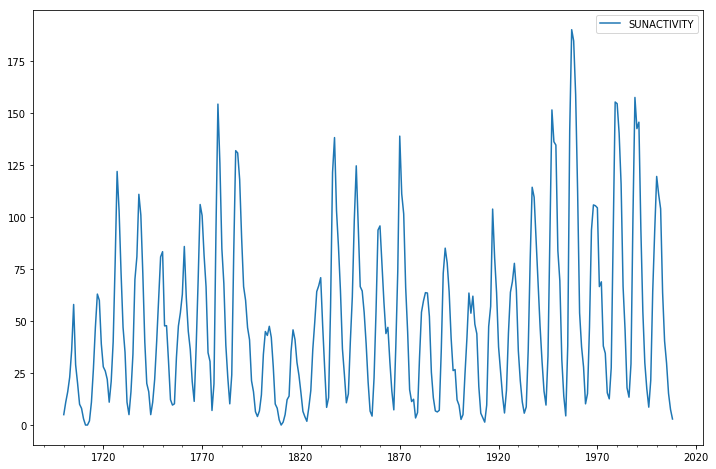

In [76]:
########导入数据
#print(sm.datasets.sunspots.NOTE)
dta = sm.datasets.sunspots.load_pandas().data
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
dta.plot(figsize=(12,8))

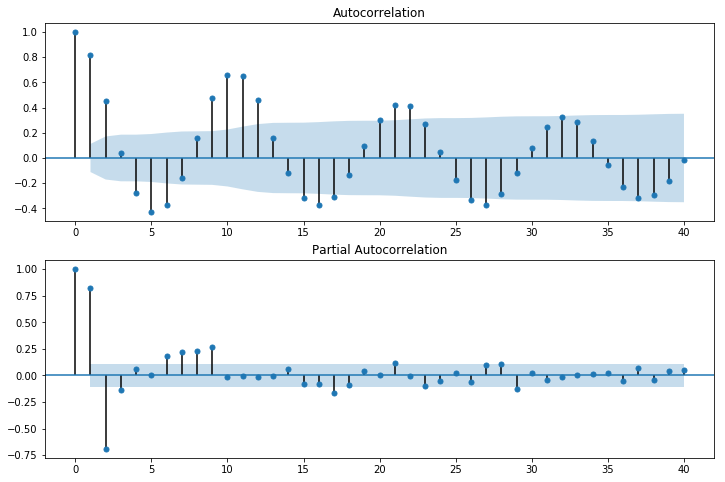

In [77]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [78]:
##########使用AR（2）模型进行模型拟合
arma_mod20 = ARIMA(dta, order=(2, 0, 0)).fit()
print(arma_mod20.params)##########查看参数

const                49.659343
ar.L1.SUNACTIVITY     1.390656
ar.L2.SUNACTIVITY    -0.688571
dtype: float64


/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/yinaihua/ENTER/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/yinaihua/ENTER/lib/python3.7/site

In [79]:
############使用AR（3）进行模型拟合
arma_mod30 = ARIMA(dta, order=(3, 0, 0)).fit()

/home/yinaihua/ENTER/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


In [82]:
##########查看参数
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)
print(arma_mod30.params)
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

2622.6363380639814 2637.569703171572 2628.6067259092274
const                49.749900
ar.L1.SUNACTIVITY     1.300810
ar.L2.SUNACTIVITY    -0.508093
ar.L3.SUNACTIVITY    -0.129649
dtype: float64
2619.4036286966957 2638.0703350811846 2626.866613503253


In [ ]:
###########例题11.3  长期利率的ESTAR模型 

In [71]:
###########例题11.4  美元汇率的马尔可夫转换模型
##############下面我们以国民生产总值为例，编写python程序，实现马尔可夫转换模型
####首先，导入相关包
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from pandas_datareader.data import DataReader
from datetime import datetime
usrec = DataReader('USREC', 'fred', start=datetime(1947, 1, 1), end=datetime(2013, 4, 1)

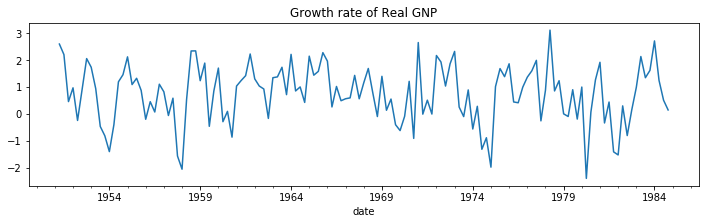

In [72]:
# 获取RGNP 数据（to replicate Hamilton）
dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq='QS')
dta_hamilton = dta.rgnp

# 绘图
dta_hamilton.plot(title='Growth rate of Real GNP', figsize=(12,3))

# 拟合模型
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [74]:
print(res_hamilton.summary())

                         Markov Switching Model Results                         
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Fri, 07 Aug 2020   AIC                            380.527
Time:                          20:19:50   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 

In [ ]:
###########例题11.5  高利率的非线性检验    

In [ ]:
###########例题17.1  实现的是The Muth Model及卡尔曼滤波器的相关公式推导，无python代码

In [ ]:
###########例17.2  实现的是Muth模型中的预测和平滑相关公式推导，无python代码

In [86]:
###########例题17.3实现的是对全球气温的状态空间模型建模
###########下面，我们对每月航空公司数据进行state space 建模
#(例题9.2实现的是一个啤酒销量的季节性ARIMA建模,也是空间状态模型建模）
########导入相关包
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [88]:
# 获取数据
from datetime import datetime
import requests
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime(data.time[0], 1, 1),periods=len(data), freq='MS')
data['lnair'] = np.log(data['air'])

# 拟合模型
mod = sm.tsa.statespace.SARIMAX(data['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())


                                 Statespace Model Results                                 
Dep. Variable:                       D.DS12.lnair   No. Observations:                  131
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 240.821
Date:                            Fri, 07 Aug 2020   AIC                           -473.643
Time:                                    21:21:18   BIC                           -462.142
Sample:                                02-01-1950   HQIC                          -468.970
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4057      0.080     -5.045      0.000      -0.563      -0.248
ar.L2         -0.0799      0.099   